# Streaming Examples: CSV, TSV, Parquet, pandas, polars

This notebook demonstrates how to:
- Generate small CSV/TSV/Parquet files for testing.
- Stream each format in chunks using `pysuricata.io.iter_chunks(...)`.
- Stream in-memory `pandas` and `polars` DataFrames.
- Build a report with `pysuricata.api.profile(...)` from any of these sources.

Notes:
- Parquet streaming requires `pyarrow`.
- Polars examples require `polars`.
- All computations operate on pandas DataFrame chunks under the hood.

In [1]:
import os, sys, math, random
import numpy as np
import pandas as pd

try:
    import polars as pl
except Exception:
    pl = None

try:
    import pyarrow as pa  # noqa: F401
except Exception:
    pa = None

from pysuricata.api import profile, ReportConfig
from pysuricata.io import iter_chunks

BASE = 'examples'
os.makedirs(BASE, exist_ok=True)
CSV_PATH = os.path.join(BASE, 'demo_users.csv')
TSV_PATH = os.path.join(BASE, 'demo_users.tsv')
PARQUET_PATH = os.path.join(BASE, 'demo_users.parquet')

def tiny_print(title, msg):
    print(f'[{title}] {msg}')


## Generate synthetic dataset and write CSV/TSV/Parquet

In [2]:
rng = np.random.default_rng(42)
N = 10_000
countries = np.array(['US','ES','DE','FR','GB','BR','IN','CN','JP'])
df = pd.DataFrame({
    'id': np.arange(N),
    'amount': rng.normal(100.0, 15.0, size=N).round(2),
    'country': countries[rng.integers(0, len(countries), size=N)],
    'flag': rng.integers(0, 2, size=N).astype(bool),
    'ts': pd.to_datetime(1.6e9 + rng.integers(0, 86_400*30, size=N), unit='s', utc=True),
})

# Save CSV/TSV
df.to_csv(CSV_PATH, index=False)
df.to_csv(TSV_PATH, index=False, sep='	')

# Save Parquet when pyarrow is available
if pa is not None:
    df.to_parquet(PARQUET_PATH, index=False)
    tiny_print('PARQUET', f'Wrote {PARQUET_PATH}')
else:
    tiny_print('PARQUET', 'pyarrow not available, skipping write')

tiny_print('CSV', f'Wrote {CSV_PATH}')
tiny_print('TSV', f'Wrote {TSV_PATH}')
df.head()


[PARQUET] pyarrow not available, skipping write
[CSV] Wrote examples/demo_users.csv
[TSV] Wrote examples/demo_users.tsv


id  amount country   flag                        ts
0   0  104.57      CN   True 2020-09-20 07:28:31+00:00
1   1   84.40      CN  False 2020-09-20 21:37:14+00:00
2   2  111.26      IN  False 2020-10-09 08:42:53+00:00
3   3  114.11      DE   True 2020-10-01 23:16:13+00:00
4   4   70.73      BR   True 2020-10-13 07:43:08+00:00

## Chunked CSV with `iter_chunks`

2025-09-05 13:47:14,044 INFO pysuricata.report_v2: Starting report generation: source=examples/demo_users.csv
2025-09-05 13:47:14,044 INFO pysuricata.report_v2: chunk_size=200000, uniques_k=2048, numeric_sample_k=20000, topk_k=50
2025-09-05 13:47:14,044 INFO pysuricata.report_v2: ▶ Build chunk iterator...
2025-09-05 13:47:14,045 INFO pysuricata.report_v2: ✓ Build chunk iterator done (0.00s)
2025-09-05 13:47:14,045 INFO pysuricata.report_v2: ▶ Read first chunk...
2025-09-05 13:47:14,052 INFO pysuricata.report_v2: ✓ Read first chunk done (0.01s)
2025-09-05 13:47:14,077 INFO pysuricata.report_v2: ▶ Infer kinds & build accumulators...
2025-09-05 13:47:14,092 INFO pysuricata.report_v2: ✓ Infer kinds & build accumulators done (0.02s)
2025-09-05 13:47:14,094 INFO pysuricata.report_v2: ▶ Consume first chunk...
2025-09-05 13:47:14,197 INFO pysuricata.report_v2: ✓ Consume first chunk done (0.10s)
2025-09-05 13:47:14,197 INFO pysuricata.report_v2: kinds: 2 numeric, 1 categorical, 1 datetime, 1 bo

[CSV-CHUNK] chunk 1 shape=(2000, 5)
[CSV-CHUNK] chunk 2 shape=(2000, 5)
[CSV-CHUNK] total rows seen=10000


2025-09-05 13:47:14,246 INFO pysuricata.report_v2: ✓ Render final HTML done (0.02s)
2025-09-05 13:47:14,246 INFO pysuricata.report_v2: ✓ Render Variables section done (0.03s)
2025-09-05 13:47:14,259 INFO pysuricata.report_v2: Report generation complete in 0.22s


[CSV-REPORT] saved examples/report_csv.html


Report(html='<!DOCTYPE html>\n<html lang="en">\n  <head>\n    <meta charset="utf-8" />\n    <meta name="viewport" content="width=device-width, initial-scale=1" />\n    <title>PySuricata EDA Report (streaming)</title>\n    <link rel="icon" href="data:image/x-icon;base64,AAABAAQAEBAAAAAAIACzAgAARgAAACAgAAAAACAAFAcAAPkCAAAwMAAAAAAgAGwMAAANCgAAQEAAAAAAIADIEgAAeRYAAIlQTkcNChoKAAAADUlIRFIAAAAQAAAAEAgGAAAAH/P/YQAAAnpJREFUeJx9kktIVHEUxn//e+9cHXNGzUchk5WUtSioFIpJMHpLRBZYECFEu+ixiDYVTJEUtQxaFvTYtCg0IpUwswiSkIKsNImyLJ2YmQbzMa/7Py2aNGXsbM7i43zn+75zYHoZ6b62Yee63sunD8YP7an+ZMJmgMAUnrGUiCjAt2/r6siDG+elr+uO8/Bmo+yvrRwDytP4NJJMjNq2XbFly5ZKZ8czvWDhAu1yuSJAMo3LrBJqwEIpgF0tty/IeLQ71nz9rAC1KIN6MGfOTFNQUo8gsKjIXpXnzcWd58Xr9VCcwwpEoP5/CYAyDAOg9HjD1hEZfS2jnx+nJPJSDtb5w0BRGlcZFdTUYGotzPcYm6r9VZ72lvZUdu4cs62l3an2V80tdLNei1AJ1qwWAJyEzguHIhL8PixnTjVKKBTW2klJKk4xolX3VJiZCASfby5tj54q9xy3+hmJqPyCPO41t6pFZQUGKFlc6qnw+XDPqiAcHZO63Tt40vmCSCRKS2uH2l67hejoxMjK8pKV2Ya6mExipJ9KWdPHFdGfcVU6v5gNJw7T1NTGxk3rGRz4ykAoFl9TkHtATLkWHGTs3J+TamumgiwXTMTilC1fwrEjpVCYT3/vB2wTyzTIVaYRn/TLjEQBkg5iWSZMxBge/kHi2xC2bZNwcLSWeU5CfmUOsRMCAW2MpwgGgyHIL1Jv3/fT1/fRjMUTjs9rnFSowneDI68CAQxA/zH9bwAoASmp9Vf0Xrl6qeD+3Qfism163vQ4z553vRDLu7f3S2govXiSQAH4INuel3PUk2Nvc5nity1XFkqhtUMi6SRiKZrG4snWgeD4LcD5u/U3YTkAkClQg+cAAAAASUVORK5CYIKJUE5HDQoaCgAAAA1JSERSAAAAIAAAACAIBgAAAHN6evQAAAbbSURBVHicrZd7cJTVFcB/937fvje7m9eGPAhBUlICASZgpaUYUOTRQjsjz1ak1j4chplWO7VMnWoIHTr0oVaddkbGqeLYDlNA6EBrHZkKWpBHA6WgRdGKgaABIZssm33k++7pHxuEaSFuxPvn953H75x77znnQmFLKwAmeSqLPWtqIhxvGObNjq0OOCOinK6Keh6HaOySbIE2AVCFyCgQAXtkuX9zQ138q0uW3E5NTRU+v4+zXefYsOEPHH/nTPuJLnsOXPxwAMIMBWQwQA0ER1dHtt8yoUIO7/xd7vTR7W7yvZfF6dorJw5sMkd2bcjMnzJC6itD+6Ak0prXKSS4j02XBZi6ythtRR5n3pzZM3MVw+KeL3x+vnpt70ESPUm5dcYiehI93oVLFuRiPnPTyCp3YRuYlrzudQMIgGV5Mo5riBZHdTxexvr161RJaYmcPNmhnnnmEZqbJyDGaMcIRrgAsHtA97rXQDrtqpjnya988TPy3uGtrrhvyQ+/NdfMvnGEkcQh03F4mzv7c3VSVex7jMvb9qktJYICRamXF3967yKR7nbnzNHtcrJ9i7jn/+E88N15UupjOyhaW4fmvBBhmTwZu5WHtMer/p1IJMB1JRaLUFkZRxxHuhM9aK0OLWKhtWNHYXs/FADmzcNtY42xLSbFolGwLOX0O2QyOSyvh4p4GbYlzZvY7N5ww9CuXyEAVlsbprw4MLs8FpzaMmOaK65jKa1QCkDssePGmEjIM6usLDJp0yZcCrwBBQGIYKDFDqjsL+bMmq6mTp1C38UUWmu01mRSfdxy63TTPP6z3rBKPwqiWlsLvwEfWweUQuKxA1+uLC0af8eyxa72+yzXzWdZKUU2m6Wkttr+zj13uVG/PS1eHJnS1obh06gDLS35amabzILJzU1SUlIi+195TSLFUYwxGGOIxmL87U9/lZqqajN2TL0o5+LcK3WvC2DXLlxQaGTU6NH1CstS3/v+Kl74y05C4RDhcIgtz+9g1apWFQgHVV3dcGUhTQDxeGHbYA9Kp/NG/F472HGqk8qGen5w30r1wI/bGDVqpDiOo1Y/9DN58MH7qRnToHp7k/j9VglJQ2OjXD9AfglFkYjnwL4DPPvYepbfd4/sP9DO2rUPo0BmzpzO4hV3q61PPcexo68TLYranLtwpYFLldH9hAAAYmxfgHU/f5R4RRkrV35bfX3p3QjIc79/SvbseFGtbltHNBLmf1qAGvhwVedQUB1Q9PT0MPXmacz60lz1myeeVNXVVYyoq2VYZYWqra3Rj//6t4wZ10RD41guppIAvPHGR87DNWWhpaWlpUVXQA0FAFwj2BqWL1vM8RPvcuSfR4nH48Tj5XR0nObY629y57LFlJVGyWUdABobWwWIja+L7i/yWw87znlbCpwRLseu8sCjyqwj935jjjjdh9y7br9ZJtYGZEZTXGZPrpGWcXG57aZ6SXbucVYsnSH1cc+eS34aaiIbmuuL00DFwKf/C7igDGilNICF8Mt1P+Frd95BeVUNRcVljGmawCO/WkM4HMBxXcSgQQiHw2WRgGd54mL/WqBrUjMerjKmFXQIBVBageMQ8nv50f0ryKTSuK5LKBzEyWZx0lksrUHlYw3bTqPH9pNzzUFAtbdfvUkNbXBQCsd1SXYnMG4/GiHZkySdyaItjdIaxCgAv1cV21qBkgAgLdfY/4IycKWmUgqt89xGBMvS+eMugjHmCrl8xFqswYtdIQACcrXCalkWgKTSGbEGuuNHdkVHBZGck0vBtWfEQQGMyQdvjOnTWoNSl42IYNkWT6zfqHp7UwrLwhiDylMYn1fPN4Lq7s6duBzHEAFWr0aBYKC3N5nEcVyUAmMMgXCIv+9tZ9++g9TWVpLpS0tfXx+Oa44Bk8sj/gW9qf5/ZeE/+ZnyExzCXbvy/23bf/Ttt97hzAdnxev10u84iGXx0s5XqKooxSoKc7rzA6ujoxPb45944+iSP2uN1XE23QoYpa7tZzAAtXs3ugXsrPZuO/fheTZu3KY9kSJCwQDa7+PUqU5EDCoQYefLe1Rv4gINw2MTg14r/u7ZdGtPOrdtUX4wuWYvGOyECpDbDfB+4tVAVXjf1i3PT6keXm0mNTfp9/cfIZFIkOzt4dUXdvLHjZsl4Pc7p8/37X+7s3dNKuu+BLBpEOdw7dpsxaO+EX6/XWcr1RDyWd+MhT1jPZYK9GX6leXxkstkCAa8KKVJZ10JehXdfW5PIpV92rb13mzW6bqQtt5MpVJnhwKQr2JhymL+4LZo0J7o81hBj60AhTGC1vm3stIa1xiQSz0jP8Aqhe53DNl+N3E+2b+xK5FZwSCv5f8Cm566v4ur1l8AAAAASUVORK5CYIKJUE5HDQoaCgAAAA1JSERSAAAAMAAAADAIBgAAAFcC+YcAAAwzSURBVHicxVl7lFXldf/t7zvn3nvOfc3ce2eAGRhAUSTqEgyPgMhIlDganYUhtLELbX00NsblarJSicVKRmhM82pa26bRGGuWqRUpj/QRi1UYEJAwyEtgFCcowzxgHndm7vue8327f9zLY3wAc++Y7j9m1l3n2+f7/fa39/723odQvkgACsC0mmjgq34vfV6SvlQKsl1XOQzZk3Gxpb0n+TSArQwQFfR4FPYGlalvAnACtve+SVW+H/uEG7
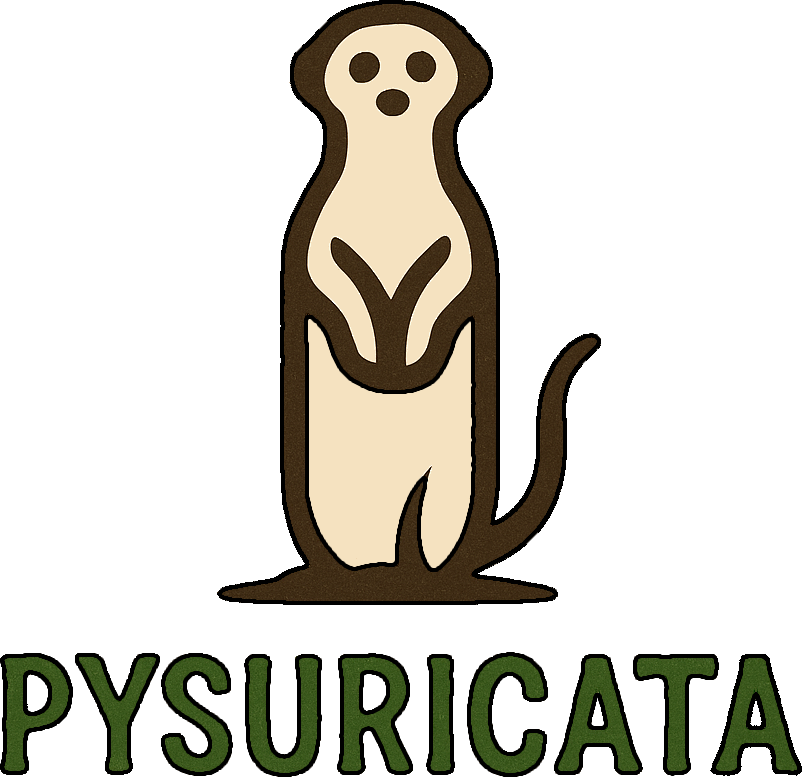
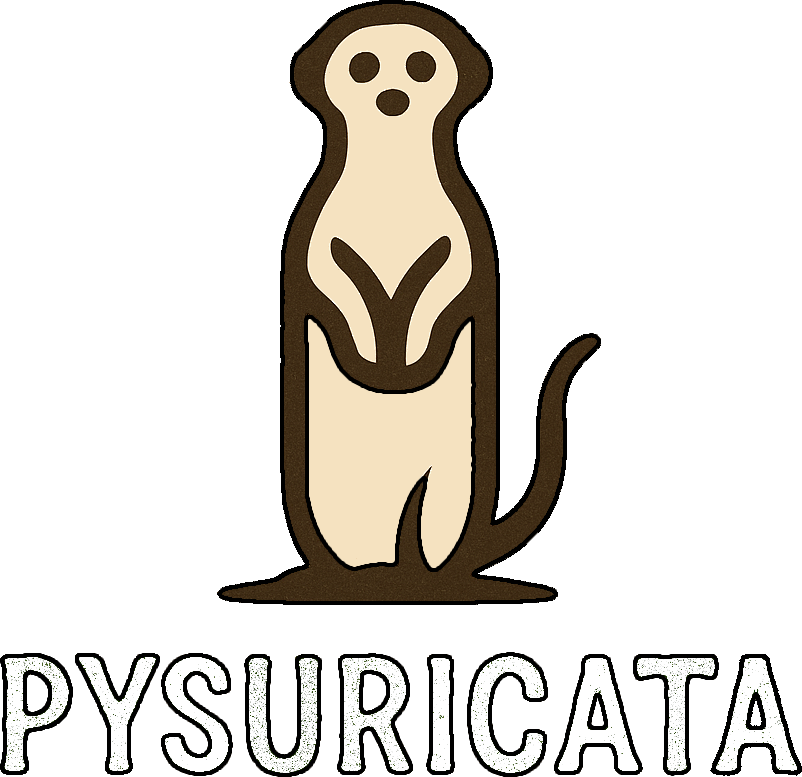

In [3]:
from pysuricata.io import iter_chunks
rows = 0
for i, ch in enumerate(iter_chunks(CSV_PATH, chunk_size=2_000, read_csv_kwargs={'sep': ','})):
    rows += len(ch)
    if i < 2:
        tiny_print('CSV-CHUNK', f'chunk {i+1} shape={ch.shape}')
tiny_print('CSV-CHUNK', f'total rows seen={rows}')

rep_csv = profile(CSV_PATH, config=ReportConfig())
rep_csv.save_html(os.path.join(BASE, 'report_csv.html'))
tiny_print('CSV-REPORT', 'saved examples/report_csv.html')
rep_csv  # displays in notebook


## Chunked TSV with `iter_chunks`

2025-09-05 13:47:14,321 INFO pysuricata.report_v2: Starting report generation: source=examples/demo_users.tsv
2025-09-05 13:47:14,321 INFO pysuricata.report_v2: chunk_size=200000, uniques_k=2048, numeric_sample_k=20000, topk_k=50
2025-09-05 13:47:14,322 INFO pysuricata.report_v2: ▶ Build chunk iterator...
2025-09-05 13:47:14,322 INFO pysuricata.report_v2: ✓ Build chunk iterator done (0.00s)
2025-09-05 13:47:14,322 INFO pysuricata.report_v2: ▶ Read first chunk...
2025-09-05 13:47:14,327 INFO pysuricata.report_v2: ✓ Read first chunk done (0.00s)
2025-09-05 13:47:14,345 INFO pysuricata.report_v2: ▶ Infer kinds & build accumulators...
2025-09-05 13:47:14,357 INFO pysuricata.report_v2: ✓ Infer kinds & build accumulators done (0.01s)
2025-09-05 13:47:14,357 INFO pysuricata.report_v2: ▶ Consume first chunk...
2025-09-05 13:47:14,451 INFO pysuricata.report_v2: ✓ Consume first chunk done (0.09s)
2025-09-05 13:47:14,451 INFO pysuricata.report_v2: kinds: 2 numeric, 1 categorical, 1 datetime, 1 bo

[TSV-CHUNK] chunk 1 shape=(2000, 5)
[TSV-CHUNK] chunk 2 shape=(2000, 5)
[TSV-CHUNK] total rows seen=10000


2025-09-05 13:47:14,471 INFO pysuricata.report_v2: ▶ Render Variables section...
2025-09-05 13:47:14,471 INFO pysuricata.report_v2: rendered 5 variable cards
2025-09-05 13:47:14,471 INFO pysuricata.report_v2: ▶ Render final HTML...
2025-09-05 13:47:14,491 INFO pysuricata.report_v2: ✓ Render final HTML done (0.02s)
2025-09-05 13:47:14,491 INFO pysuricata.report_v2: ✓ Render Variables section done (0.02s)
2025-09-05 13:47:14,506 INFO pysuricata.report_v2: Report generation complete in 0.19s


[TSV-REPORT] saved examples/report_tsv.html


Report(html='<!DOCTYPE html>\n<html lang="en">\n  <head>\n    <meta charset="utf-8" />\n    <meta name="viewport" content="width=device-width, initial-scale=1" />\n    <title>PySuricata EDA Report (streaming)</title>\n    <link rel="icon" href="data:image/x-icon;base64,AAABAAQAEBAAAAAAIACzAgAARgAAACAgAAAAACAAFAcAAPkCAAAwMAAAAAAgAGwMAAANCgAAQEAAAAAAIADIEgAAeRYAAIlQTkcNChoKAAAADUlIRFIAAAAQAAAAEAgGAAAAH/P/YQAAAnpJREFUeJx9kktIVHEUxn//e+9cHXNGzUchk5WUtSioFIpJMHpLRBZYECFEu+ixiDYVTJEUtQxaFvTYtCg0IpUwswiSkIKsNImyLJ2YmQbzMa/7Py2aNGXsbM7i43zn+75zYHoZ6b62Yee63sunD8YP7an+ZMJmgMAUnrGUiCjAt2/r6siDG+elr+uO8/Bmo+yvrRwDytP4NJJMjNq2XbFly5ZKZ8czvWDhAu1yuSJAMo3LrBJqwEIpgF0tty/IeLQ71nz9rAC1KIN6MGfOTFNQUo8gsKjIXpXnzcWd58Xr9VCcwwpEoP5/CYAyDAOg9HjD1hEZfS2jnx+nJPJSDtb5w0BRGlcZFdTUYGotzPcYm6r9VZ72lvZUdu4cs62l3an2V80tdLNei1AJ1qwWAJyEzguHIhL8PixnTjVKKBTW2klJKk4xolX3VJiZCASfby5tj54q9xy3+hmJqPyCPO41t6pFZQUGKFlc6qnw+XDPqiAcHZO63Tt40vmCSCRKS2uH2l67hejoxMjK8pKV2Ya6mExipJ9KWdPHFdGfcVU6v5gNJw7T1NTGxk3rGRz4ykAoFl9TkHtATLkWHGTs3J+TamumgiwXTMTilC1fwrEjpVCYT3/vB2wTyzTIVaYRn/TLjEQBkg5iWSZMxBge/kHi2xC2bZNwcLSWeU5CfmUOsRMCAW2MpwgGgyHIL1Jv3/fT1/fRjMUTjs9rnFSowneDI68CAQxA/zH9bwAoASmp9Vf0Xrl6qeD+3Qfism163vQ4z553vRDLu7f3S2govXiSQAH4INuel3PUk2Nvc5nity1XFkqhtUMi6SRiKZrG4snWgeD4LcD5u/U3YTkAkClQg+cAAAAASUVORK5CYIKJUE5HDQoaCgAAAA1JSERSAAAAIAAAACAIBgAAAHN6evQAAAbbSURBVHicrZd7cJTVFcB/937fvje7m9eGPAhBUlICASZgpaUYUOTRQjsjz1ak1j4chplWO7VMnWoIHTr0oVaddkbGqeLYDlNA6EBrHZkKWpBHA6WgRdGKgaABIZssm33k++7pHxuEaSFuxPvn953H75x77znnQmFLKwAmeSqLPWtqIhxvGObNjq0OOCOinK6Keh6HaOySbIE2AVCFyCgQAXtkuX9zQ138q0uW3E5NTRU+v4+zXefYsOEPHH/nTPuJLnsOXPxwAMIMBWQwQA0ER1dHtt8yoUIO7/xd7vTR7W7yvZfF6dorJw5sMkd2bcjMnzJC6itD+6Ak0prXKSS4j02XBZi6ythtRR5n3pzZM3MVw+KeL3x+vnpt70ESPUm5dcYiehI93oVLFuRiPnPTyCp3YRuYlrzudQMIgGV5Mo5riBZHdTxexvr161RJaYmcPNmhnnnmEZqbJyDGaMcIRrgAsHtA97rXQDrtqpjnya988TPy3uGtrrhvyQ+/NdfMvnGEkcQh03F4mzv7c3VSVex7jMvb9qktJYICRamXF3967yKR7nbnzNHtcrJ9i7jn/+E88N15UupjOyhaW4fmvBBhmTwZu5WHtMer/p1IJMB1JRaLUFkZRxxHuhM9aK0OLWKhtWNHYXs/FADmzcNtY42xLSbFolGwLOX0O2QyOSyvh4p4GbYlzZvY7N5ww9CuXyEAVlsbprw4MLs8FpzaMmOaK65jKa1QCkDssePGmEjIM6usLDJp0yZcCrwBBQGIYKDFDqjsL+bMmq6mTp1C38UUWmu01mRSfdxy63TTPP6z3rBKPwqiWlsLvwEfWweUQuKxA1+uLC0af8eyxa72+yzXzWdZKUU2m6Wkttr+zj13uVG/PS1eHJnS1obh06gDLS35amabzILJzU1SUlIi+195TSLFUYwxGGOIxmL87U9/lZqqajN2TL0o5+LcK3WvC2DXLlxQaGTU6NH1CstS3/v+Kl74y05C4RDhcIgtz+9g1apWFQgHVV3dcGUhTQDxeGHbYA9Kp/NG/F472HGqk8qGen5w30r1wI/bGDVqpDiOo1Y/9DN58MH7qRnToHp7k/j9VglJQ2OjXD9AfglFkYjnwL4DPPvYepbfd4/sP9DO2rUPo0BmzpzO4hV3q61PPcexo68TLYranLtwpYFLldH9hAAAYmxfgHU/f5R4RRkrV35bfX3p3QjIc79/SvbseFGtbltHNBLmf1qAGvhwVedQUB1Q9PT0MPXmacz60lz1myeeVNXVVYyoq2VYZYWqra3Rj//6t4wZ10RD41guppIAvPHGR87DNWWhpaWlpUVXQA0FAFwj2BqWL1vM8RPvcuSfR4nH48Tj5XR0nObY629y57LFlJVGyWUdABobWwWIja+L7i/yWw87znlbCpwRLseu8sCjyqwj935jjjjdh9y7br9ZJtYGZEZTXGZPrpGWcXG57aZ6SXbucVYsnSH1cc+eS34aaiIbmuuL00DFwKf/C7igDGilNICF8Mt1P+Frd95BeVUNRcVljGmawCO/WkM4HMBxXcSgQQiHw2WRgGd54mL/WqBrUjMerjKmFXQIBVBageMQ8nv50f0ryKTSuK5LKBzEyWZx0lksrUHlYw3bTqPH9pNzzUFAtbdfvUkNbXBQCsd1SXYnMG4/GiHZkySdyaItjdIaxCgAv1cV21qBkgAgLdfY/4IycKWmUgqt89xGBMvS+eMugjHmCrl8xFqswYtdIQACcrXCalkWgKTSGbEGuuNHdkVHBZGck0vBtWfEQQGMyQdvjOnTWoNSl42IYNkWT6zfqHp7UwrLwhiDylMYn1fPN4Lq7s6duBzHEAFWr0aBYKC3N5nEcVyUAmMMgXCIv+9tZ9++g9TWVpLpS0tfXx+Oa44Bk8sj/gW9qf5/ZeE/+ZnyExzCXbvy/23bf/Ttt97hzAdnxev10u84iGXx0s5XqKooxSoKc7rzA6ujoxPb45944+iSP2uN1XE23QoYpa7tZzAAtXs3ugXsrPZuO/fheTZu3KY9kSJCwQDa7+PUqU5EDCoQYefLe1Rv4gINw2MTg14r/u7ZdGtPOrdtUX4wuWYvGOyECpDbDfB+4tVAVXjf1i3PT6keXm0mNTfp9/cfIZFIkOzt4dUXdvLHjZsl4Pc7p8/37X+7s3dNKuu+BLBpEOdw7dpsxaO+EX6/XWcr1RDyWd+MhT1jPZYK9GX6leXxkstkCAa8KKVJZ10JehXdfW5PIpV92rb13mzW6bqQtt5MpVJnhwKQr2JhymL+4LZo0J7o81hBj60AhTGC1vm3stIa1xiQSz0jP8Aqhe53DNl+N3E+2b+xK5FZwSCv5f8Cm566v4ur1l8AAAAASUVORK5CYIKJUE5HDQoaCgAAAA1JSERSAAAAMAAAADAIBgAAAFcC+YcAAAwzSURBVHicxVl7lFXldf/t7zvn3nvOfc3ce2eAGRhAUSTqEgyPgMhIlDganYUhtLELbX00NsblarJSicVKRmhM82pa26bRGGuWqRUpj/QRi1UYEJAwyEtgFCcowzxgHndm7vue8327f9zLY3wAc++Y7j9m1l3n2+f7/fa39/723odQvkgACsC0mmjgq34vfV6SvlQKsl1XOQzZk3Gxpb0n+TSArQwQFfR4FPYGlalvAnACtve+SVW+H/uEG7
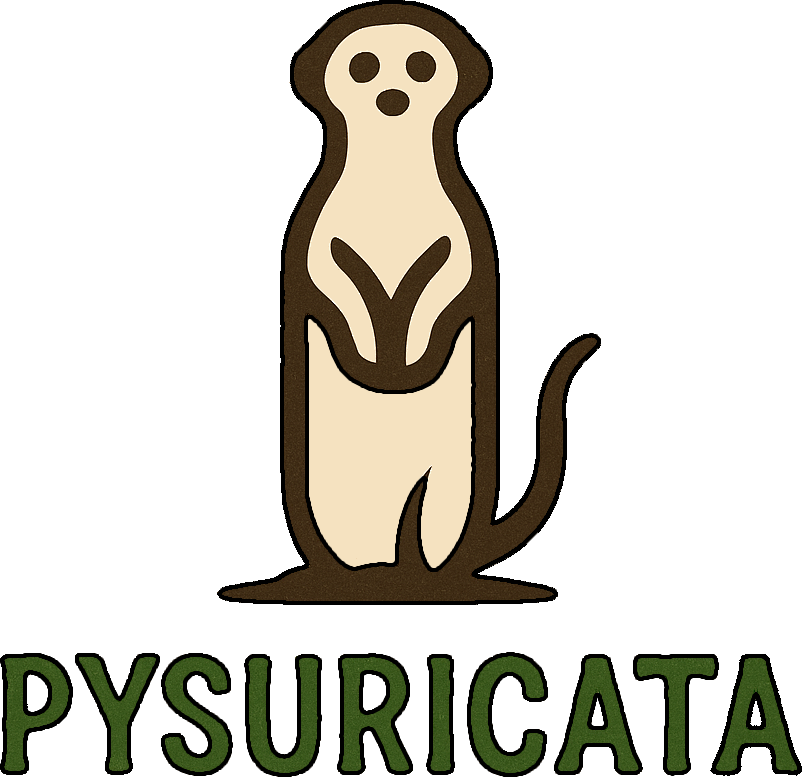
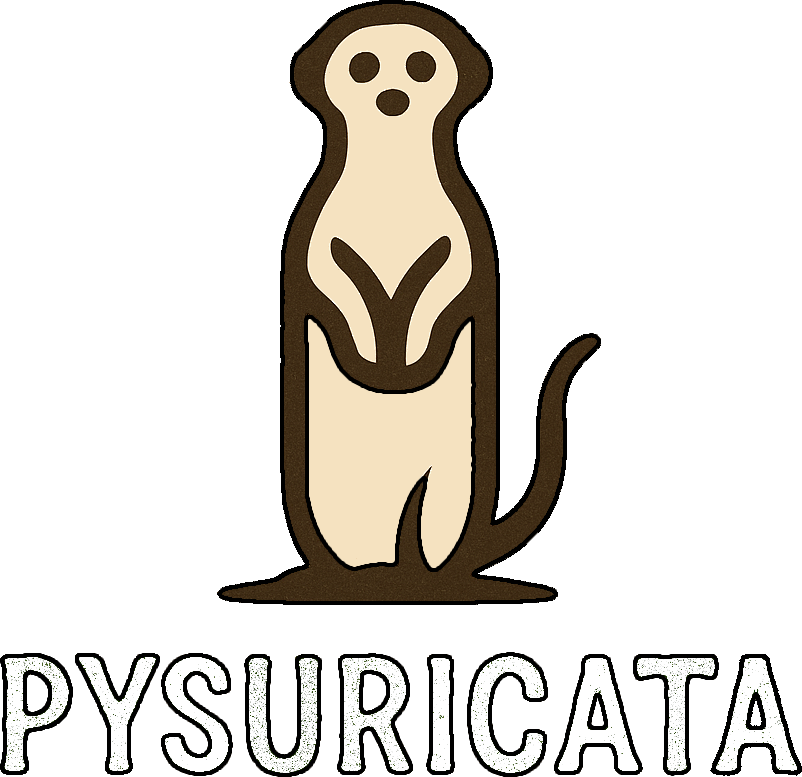

In [4]:
rows = 0
for i, ch in enumerate(iter_chunks(TSV_PATH, chunk_size=2_000, read_csv_kwargs={'sep': '	'})):
    rows += len(ch)
    if i < 2:
        tiny_print('TSV-CHUNK', f'chunk {i+1} shape={ch.shape}')
tiny_print('TSV-CHUNK', f'total rows seen={rows}')

rep_tsv = profile(TSV_PATH, config=ReportConfig())
rep_tsv.save_html(os.path.join(BASE, 'report_tsv.html'))
tiny_print('TSV-REPORT', 'saved examples/report_tsv.html')
rep_tsv


## Chunked Parquet with `iter_chunks` (pyarrow)

In [5]:
if pa is not None and os.path.exists(PARQUET_PATH):
    rows = 0
    for i, ch in enumerate(iter_chunks(PARQUET_PATH, chunk_size=2_000)):
        rows += len(ch)
        if i < 2:
            tiny_print('PQ-CHUNK', f'chunk {i+1} shape={ch.shape}')
    tiny_print('PQ-CHUNK', f'total rows seen={rows}')
    
    rep_pq = profile(PARQUET_PATH, config=ReportConfig())
    rep_pq.save_html(os.path.join(BASE, 'report_parquet.html'))
    tiny_print('PQ-REPORT', 'saved examples/report_parquet.html')
    rep_pq
else:
    tiny_print('PQ', 'pyarrow not available or parquet not written; skipping')


[PQ] pyarrow not available or parquet not written; skipping


## In-memory pandas DataFrame (chunked)

2025-09-05 13:47:14,558 INFO pysuricata.report_v2: Starting report generation: source=DataFrame
2025-09-05 13:47:14,558 INFO pysuricata.report_v2: chunk_size=200000, uniques_k=2048, numeric_sample_k=20000, topk_k=50
2025-09-05 13:47:14,559 INFO pysuricata.report_v2: ▶ Build chunk iterator...
2025-09-05 13:47:14,559 INFO pysuricata.report_v2: ✓ Build chunk iterator done (0.00s)
2025-09-05 13:47:14,559 INFO pysuricata.report_v2: ▶ Read first chunk...
2025-09-05 13:47:14,559 INFO pysuricata.report_v2: ✓ Read first chunk done (0.00s)
2025-09-05 13:47:14,567 INFO pysuricata.report_v2: ▶ Infer kinds & build accumulators...
2025-09-05 13:47:14,569 INFO pysuricata.report_v2: ✓ Infer kinds & build accumulators done (0.00s)
2025-09-05 13:47:14,569 INFO pysuricata.report_v2: ▶ Consume first chunk...
2025-09-05 13:47:14,589 INFO pysuricata.report_v2: ✓ Consume first chunk done (0.02s)
2025-09-05 13:47:14,589 INFO pysuricata.report_v2: kinds: 2 numeric, 1 categorical, 1 datetime, 1 boolean
2025-09-

[PD-CHUNK] chunk 1 shape=(1500, 5)
[PD-CHUNK] chunk 2 shape=(1500, 5)
[PD-CHUNK] total rows seen=10000


2025-09-05 13:47:14,725 INFO pysuricata.report_v2: ✓ Render final HTML done (0.02s)
2025-09-05 13:47:14,725 INFO pysuricata.report_v2: ✓ Render Variables section done (0.02s)
2025-09-05 13:47:14,737 INFO pysuricata.report_v2: Report generation complete in 0.18s


[PD-REPORT] saved examples/report_pandas_inmemory.html


Report(html='<!DOCTYPE html>\n<html lang="en">\n  <head>\n    <meta charset="utf-8" />\n    <meta name="viewport" content="width=device-width, initial-scale=1" />\n    <title>PySuricata EDA Report (streaming)</title>\n    <link rel="icon" href="data:image/x-icon;base64,AAABAAQAEBAAAAAAIACzAgAARgAAACAgAAAAACAAFAcAAPkCAAAwMAAAAAAgAGwMAAANCgAAQEAAAAAAIADIEgAAeRYAAIlQTkcNChoKAAAADUlIRFIAAAAQAAAAEAgGAAAAH/P/YQAAAnpJREFUeJx9kktIVHEUxn//e+9cHXNGzUchk5WUtSioFIpJMHpLRBZYECFEu+ixiDYVTJEUtQxaFvTYtCg0IpUwswiSkIKsNImyLJ2YmQbzMa/7Py2aNGXsbM7i43zn+75zYHoZ6b62Yee63sunD8YP7an+ZMJmgMAUnrGUiCjAt2/r6siDG+elr+uO8/Bmo+yvrRwDytP4NJJMjNq2XbFly5ZKZ8czvWDhAu1yuSJAMo3LrBJqwEIpgF0tty/IeLQ71nz9rAC1KIN6MGfOTFNQUo8gsKjIXpXnzcWd58Xr9VCcwwpEoP5/CYAyDAOg9HjD1hEZfS2jnx+nJPJSDtb5w0BRGlcZFdTUYGotzPcYm6r9VZ72lvZUdu4cs62l3an2V80tdLNei1AJ1qwWAJyEzguHIhL8PixnTjVKKBTW2klJKk4xolX3VJiZCASfby5tj54q9xy3+hmJqPyCPO41t6pFZQUGKFlc6qnw+XDPqiAcHZO63Tt40vmCSCRKS2uH2l67hejoxMjK8pKV2Ya6mExipJ9KWdPHFdGfcVU6v5gNJw7T1NTGxk3rGRz4ykAoFl9TkHtATLkWHGTs3J+TamumgiwXTMTilC1fwrEjpVCYT3/vB2wTyzTIVaYRn/TLjEQBkg5iWSZMxBge/kHi2xC2bZNwcLSWeU5CfmUOsRMCAW2MpwgGgyHIL1Jv3/fT1/fRjMUTjs9rnFSowneDI68CAQxA/zH9bwAoASmp9Vf0Xrl6qeD+3Qfism163vQ4z553vRDLu7f3S2govXiSQAH4INuel3PUk2Nvc5nity1XFkqhtUMi6SRiKZrG4snWgeD4LcD5u/U3YTkAkClQg+cAAAAASUVORK5CYIKJUE5HDQoaCgAAAA1JSERSAAAAIAAAACAIBgAAAHN6evQAAAbbSURBVHicrZd7cJTVFcB/937fvje7m9eGPAhBUlICASZgpaUYUOTRQjsjz1ak1j4chplWO7VMnWoIHTr0oVaddkbGqeLYDlNA6EBrHZkKWpBHA6WgRdGKgaABIZssm33k++7pHxuEaSFuxPvn953H75x77znnQmFLKwAmeSqLPWtqIhxvGObNjq0OOCOinK6Keh6HaOySbIE2AVCFyCgQAXtkuX9zQ138q0uW3E5NTRU+v4+zXefYsOEPHH/nTPuJLnsOXPxwAMIMBWQwQA0ER1dHtt8yoUIO7/xd7vTR7W7yvZfF6dorJw5sMkd2bcjMnzJC6itD+6Ak0prXKSS4j02XBZi6ythtRR5n3pzZM3MVw+KeL3x+vnpt70ESPUm5dcYiehI93oVLFuRiPnPTyCp3YRuYlrzudQMIgGV5Mo5riBZHdTxexvr161RJaYmcPNmhnnnmEZqbJyDGaMcIRrgAsHtA97rXQDrtqpjnya988TPy3uGtrrhvyQ+/NdfMvnGEkcQh03F4mzv7c3VSVex7jMvb9qktJYICRamXF3967yKR7nbnzNHtcrJ9i7jn/+E88N15UupjOyhaW4fmvBBhmTwZu5WHtMer/p1IJMB1JRaLUFkZRxxHuhM9aK0OLWKhtWNHYXs/FADmzcNtY42xLSbFolGwLOX0O2QyOSyvh4p4GbYlzZvY7N5ww9CuXyEAVlsbprw4MLs8FpzaMmOaK65jKa1QCkDssePGmEjIM6usLDJp0yZcCrwBBQGIYKDFDqjsL+bMmq6mTp1C38UUWmu01mRSfdxy63TTPP6z3rBKPwqiWlsLvwEfWweUQuKxA1+uLC0af8eyxa72+yzXzWdZKUU2m6Wkttr+zj13uVG/PS1eHJnS1obh06gDLS35amabzILJzU1SUlIi+195TSLFUYwxGGOIxmL87U9/lZqqajN2TL0o5+LcK3WvC2DXLlxQaGTU6NH1CstS3/v+Kl74y05C4RDhcIgtz+9g1apWFQgHVV3dcGUhTQDxeGHbYA9Kp/NG/F472HGqk8qGen5w30r1wI/bGDVqpDiOo1Y/9DN58MH7qRnToHp7k/j9VglJQ2OjXD9AfglFkYjnwL4DPPvYepbfd4/sP9DO2rUPo0BmzpzO4hV3q61PPcexo68TLYranLtwpYFLldH9hAAAYmxfgHU/f5R4RRkrV35bfX3p3QjIc79/SvbseFGtbltHNBLmf1qAGvhwVedQUB1Q9PT0MPXmacz60lz1myeeVNXVVYyoq2VYZYWqra3Rj//6t4wZ10RD41guppIAvPHGR87DNWWhpaWlpUVXQA0FAFwj2BqWL1vM8RPvcuSfR4nH48Tj5XR0nObY629y57LFlJVGyWUdABobWwWIja+L7i/yWw87znlbCpwRLseu8sCjyqwj935jjjjdh9y7br9ZJtYGZEZTXGZPrpGWcXG57aZ6SXbucVYsnSH1cc+eS34aaiIbmuuL00DFwKf/C7igDGilNICF8Mt1P+Frd95BeVUNRcVljGmawCO/WkM4HMBxXcSgQQiHw2WRgGd54mL/WqBrUjMerjKmFXQIBVBageMQ8nv50f0ryKTSuK5LKBzEyWZx0lksrUHlYw3bTqPH9pNzzUFAtbdfvUkNbXBQCsd1SXYnMG4/GiHZkySdyaItjdIaxCgAv1cV21qBkgAgLdfY/4IycKWmUgqt89xGBMvS+eMugjHmCrl8xFqswYtdIQACcrXCalkWgKTSGbEGuuNHdkVHBZGck0vBtWfEQQGMyQdvjOnTWoNSl42IYNkWT6zfqHp7UwrLwhiDylMYn1fPN4Lq7s6duBzHEAFWr0aBYKC3N5nEcVyUAmMMgXCIv+9tZ9++g9TWVpLpS0tfXx+Oa44Bk8sj/gW9qf5/ZeE/+ZnyExzCXbvy/23bf/Ttt97hzAdnxev10u84iGXx0s5XqKooxSoKc7rzA6ujoxPb45944+iSP2uN1XE23QoYpa7tZzAAtXs3ugXsrPZuO/fheTZu3KY9kSJCwQDa7+PUqU5EDCoQYefLe1Rv4gINw2MTg14r/u7ZdGtPOrdtUX4wuWYvGOyECpDbDfB+4tVAVXjf1i3PT6keXm0mNTfp9/cfIZFIkOzt4dUXdvLHjZsl4Pc7p8/37X+7s3dNKuu+BLBpEOdw7dpsxaO+EX6/XWcr1RDyWd+MhT1jPZYK9GX6leXxkstkCAa8KKVJZ10JehXdfW5PIpV92rb13mzW6bqQtt5MpVJnhwKQr2JhymL+4LZo0J7o81hBj60AhTGC1vm3stIa1xiQSz0jP8Aqhe53DNl+N3E+2b+xK5FZwSCv5f8Cm566v4ur1l8AAAAASUVORK5CYIKJUE5HDQoaCgAAAA1JSERSAAAAMAAAADAIBgAAAFcC+YcAAAwzSURBVHicxVl7lFXldf/t7zvn3nvOfc3ce2eAGRhAUSTqEgyPgMhIlDganYUhtLELbX00NsblarJSicVKRmhM82pa26bRGGuWqRUpj/QRi1UYEJAwyEtgFCcowzxgHndm7vue8327f9zLY3wAc++Y7j9m1l3n2+f7/fa39/723odQvkgACsC0mmjgq34vfV6SvlQKsl1XOQzZk3Gxpb0n+TSArQwQFfR4FPYGlalvAnACtve+SVW+H/uEG7
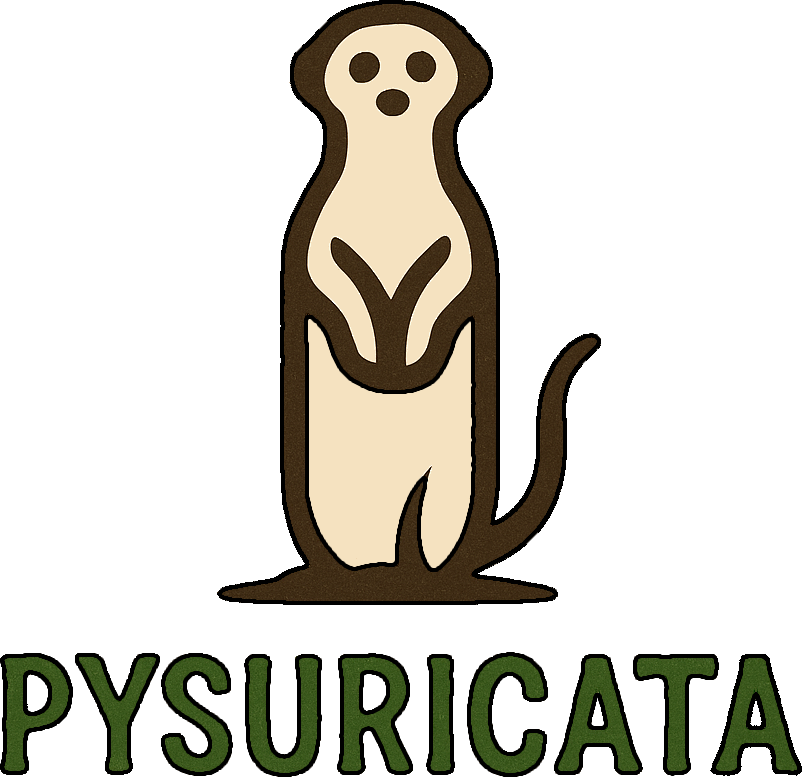
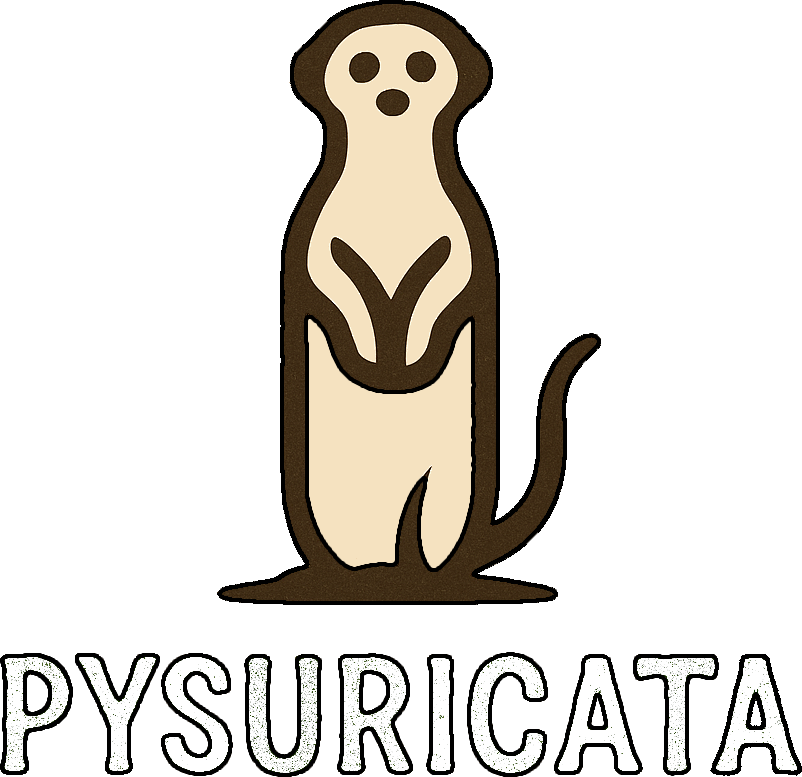

In [6]:
rows = 0
for i, ch in enumerate(iter_chunks(df, chunk_size=1_500)):
    rows += len(ch)
    if i < 2:
        tiny_print('PD-CHUNK', f'chunk {i+1} shape={ch.shape}')
tiny_print('PD-CHUNK', f'total rows seen={rows}')

rep_pd = profile(iter_chunks(df, chunk_size=2_000))
rep_pd.save_html(os.path.join(BASE, 'report_pandas_inmemory.html'))
tiny_print('PD-REPORT', 'saved examples/report_pandas_inmemory.html')
rep_pd


## In-memory polars DataFrame (chunked)

In [7]:
if pl is not None:
    pl_df = pl.from_pandas(df)
    rows = 0
    for i, ch in enumerate(iter_chunks(pl_df, chunk_size=2_000)):
        rows += len(ch)
        if i < 2:
            tiny_print('PL-CHUNK', f'chunk {i+1} shape={ch.shape}')
    tiny_print('PL-CHUNK', f'total rows seen={rows}')
    
    rep_pl = profile(iter_chunks(pl_df, chunk_size=2_000))
    rep_pl.save_html(os.path.join(BASE, 'report_polars_inmemory.html'))
    tiny_print('PL-REPORT', 'saved examples/report_polars_inmemory.html')
    rep_pl
else:
    tiny_print('POLARS', 'polars not available; skipping')


[POLARS] polars not available; skipping


## Optional: polars LazyFrame (chunked)

In [8]:
if pl is not None:
    lf = pl.from_pandas(df).lazy()
    rep_pl_lazy = profile(iter_chunks(lf, chunk_size=2_000))
    rep_pl_lazy.save_html(os.path.join(BASE, 'report_polars_lazyframe.html'))
    tiny_print('PL-LAZY', 'saved examples/report_polars_lazyframe.html')
    rep_pl_lazy
else:
    tiny_print('POLARS', 'polars not available; skipping lazy example')


[POLARS] polars not available; skipping lazy example
